## AdImpact: Quantitative Evaluation of Advertising Campaigns through A/B Testing



Setting Up Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from google.colab import files

import statsmodels.api as sm
from scipy.stats import chi2_contingency
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

Importing Dataset

In [2]:
# Mounting Google Drive
drive.mount('/content/drive')

# Path to Excel file on Google Drive
file_path = '/content/drive/My Drive/Data/marketing_AB.csv'

# Loading the sheets into dataframes
df = pd.read_csv(file_path)

Mounted at /content/drive


In [3]:
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


### Data Cleaning

In [4]:
# Rename the columns for clarity
df.columns

df = df.rename(columns={
    "Unnamed: 0": "index",
    "user id": "id_user",
    "test group": "test_group",
    "total ads": "total_ads",
    "most ads day": "most_ads_day",
    "most ads hour": "most_ads_hour"
})
df.head()

# Remove the 'index' column
df = df.drop("index", axis=1)
df.head()

,id_user,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


### Exploration of dataset

#### Tables and Figures

In [5]:
# Display the total number of observations and variables
print("Total observations:", df.shape[0])
print("Number of variables:", df.shape[1])

Total observations: 588101
Number of variables: 6


In [6]:
# Display descriptive statistics for all columns except 'id_user' with no decimals
pd.set_option('display.precision', 0)

# Create a styled table with no decimals shown
styled_table = df.drop('id_user', axis=1).describe().style.format("{:.0f}").set_table_styles(
    [{
        'selector': 'th',
        'props': [('background-color', '#f4f4f4'), ('color', 'black'), ('font-family', 'Arial'), ('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]
    }, {
        'selector': 'td',
        'props': [('background-color', 'white'), ('color', 'black'), ('font-family', 'Arial'), ('text-align', 'right'), ('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]
    }]
).set_caption("Descriptive Statistics")

# Display the styled table
styled_table


,total_ads,most_ads_hour
count,588101,588101
mean,25,14
std,44,5
min,1,0
25%,4,11
50%,13,14
75%,27,18
max,2065,23


The dataset, consisting of observations from 588,101 participants, provides a rich foundation for understanding the dynamics of advertising exposure and effectiveness. Descriptive statistics indicate that participants are exposed to an average of 25 ads, with a substantial range in individual ad exposure, varying from 1 to 2,065 ads. Notably, most ads are viewed around 2 PM, highlighting peak viewing times in the early afternoon to evening

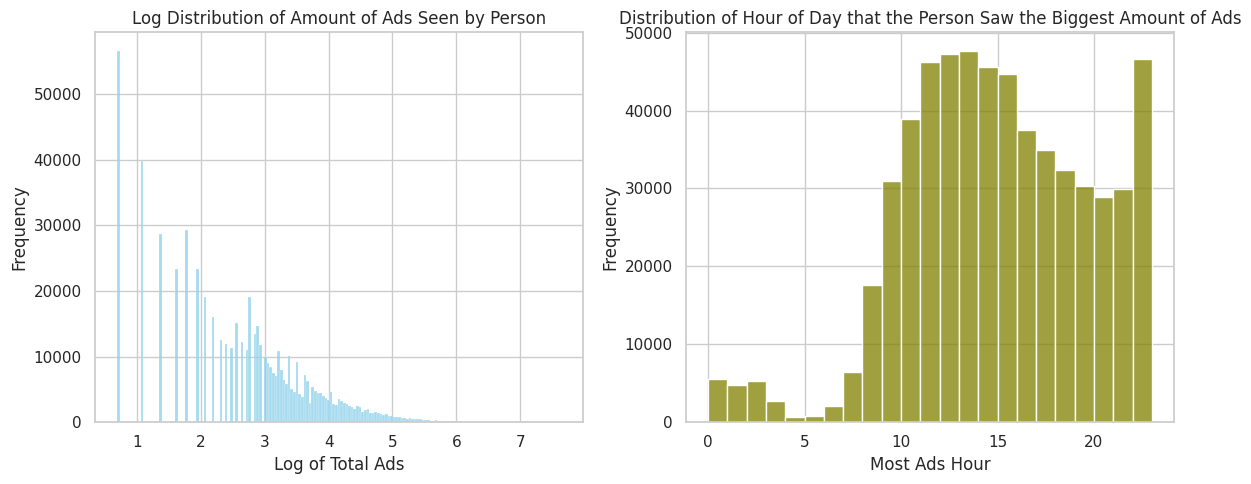

In [7]:

# Set the style and size of the plots
sns.set(style="whitegrid")
plt.figure(figsize=(12, 5))  # Adjusted size to make graphs smaller

# Create a subplot for the first variable with log transformation
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Add a small constant if data contains zero to allow log transformation
adjusted_total_ads = df['total_ads'] + 1
sns.histplot(np.log(adjusted_total_ads), kde=False, color="skyblue")
plt.title('Log Distribution of Amount of Ads Seen by Person')
plt.xlabel('Log of Total Ads')
plt.ylabel('Frequency')

# Create a subplot for the second variable
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(df['most_ads_hour'], kde=False, color="olive", binwidth=1)
plt.title('Distribution of Hour of Day that the Person Saw the Biggest Amount of Ads')
plt.xlabel('Most Ads Hour')
plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



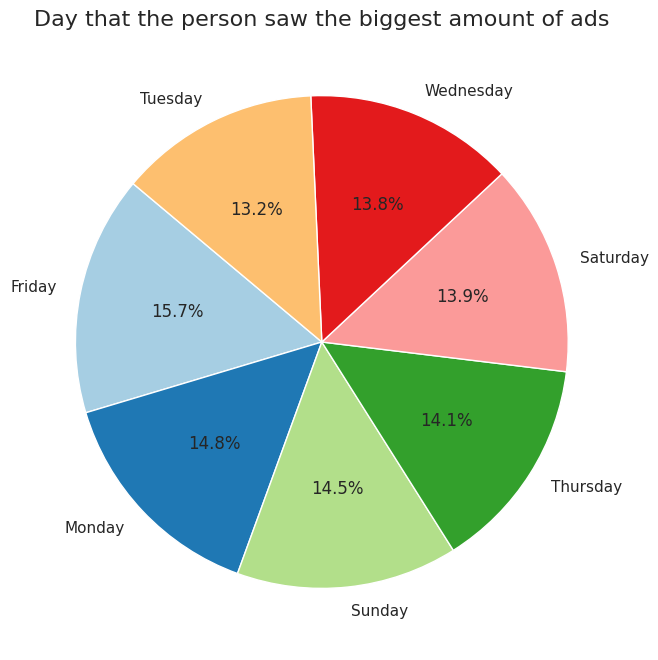

In [8]:

# Calculate counts of ads on each day
day_counts = df['most_ads_day'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))  # Set figure size
plt.pie(day_counts, labels=day_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(day_counts))))
plt.title('Day that the person saw the biggest amount of ads', fontsize=16)  # Increase font size of the title
plt.show()


The pie chart analysis illustrates how ad views are distributed throughout the week. Friday stands out as the peak day with 15.7% of total views, signaling a surge in engagement or online activity. Though Sunday sees fewer views, the weekend collectively shows robust interaction, with Saturdays and Sundays combined indicating substantial viewer activity. This spread is relatively consistent, with daily percentages ranging narrowly from 13.2% to 15.7%, suggesting a stable viewer engagement throughout the week.

In [9]:

# Set display format to avoid scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

# Calculate and style the distribution of values in the 'test_group' column as percentages
test_group_distribution = df["test_group"].value_counts(normalize=True).to_frame('Percentage')
styled_test_group = test_group_distribution.style.format("{:.0%}").set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#f4f4f4'), ('color', 'black'), ('font-family', 'Arial'), ('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]},
     {'selector': 'td', 'props': [('background-color', 'white'), ('color', 'black'), ('font-family', 'Arial'), ('text-align', 'center'), ('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}
    ]).set_caption("Distribution of Test Groups")

# Calculate and style the distribution of values in the 'converted' column as percentages
converted_distribution = df["converted"].value_counts(normalize=True).to_frame('Percentage')
styled_converted = converted_distribution.style.format("{:.0%}").set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#f4f4f4'), ('color', 'black'), ('font-family', 'Arial'), ('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]},
     {'selector': 'td', 'props': [('background-color', 'white'), ('color', 'black'), ('font-family', 'Arial'), ('text-align', 'center'), ('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}
    ]).set_caption("Distribution of Conversion Status")

# Display styled tables
styled_test_group



,Percentage
test_group,
ad,96%
psa,4%


In [10]:
styled_converted

,Percentage
converted,
False,97%
True,3%


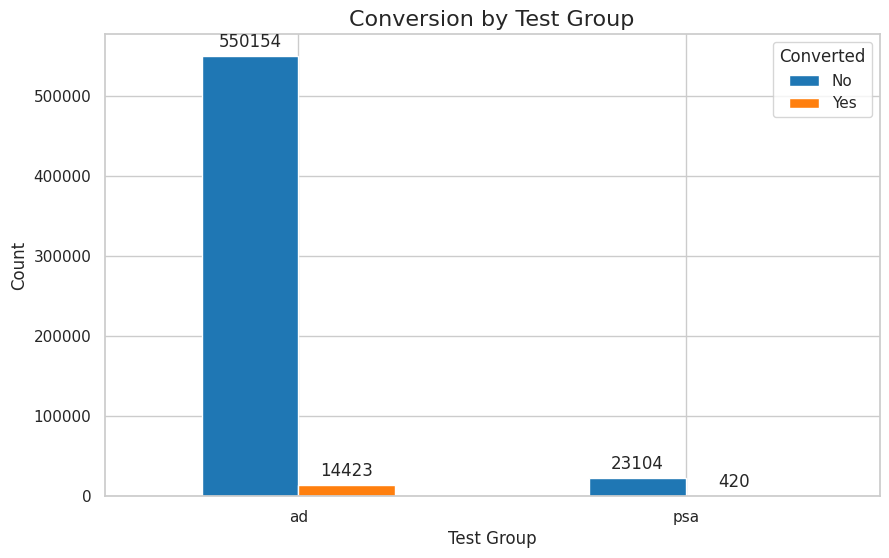

In [12]:

# Create a cross-tabulation of the two variables
data_ct = pd.crosstab(df['test_group'], df['converted'])

# Plotting the cross-tabulation
ax = data_ct.plot(kind='bar', figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])
plt.title('Conversion by Test Group', fontsize=16)
plt.xlabel('Test Group')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keeps the labels on the x-axis vertical
plt.legend(title='Converted', labels=['No', 'Yes'])

# Add text annotations
for p in ax.patches:  # loop to find the position of each bar
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


In [13]:
# Compare the conversion rate between the two test groups
pd.set_option('display.float_format', '{:.2f}'.format)
df.groupby("test_group")["converted"].value_counts(normalize=True)

test_group  converted
ad          False       0.97
            True        0.03
psa         False       0.98
            True        0.02
Name: proportion, dtype: float64

The conversion analysis via a bar chart reveals distinct differences between two test groups: 'ad' (targeted advertisements) and 'psa' (public service announcements). The 'ad' group encompasses a large segment of participants but records a low conversion rate with 550,154 non-converters and 14,423 converters, translating to a conversion rate of approximately 3%. In contrast, the smaller 'psa' group consists of 23,104 non-converters and 420 converters, reflecting an even lower conversion rate of about 2%. This stark contrast in group sizes and conversion rates underscores the need for a nuanced analysis of advertising effectiveness.

In [14]:
# Display information about the DataFrame including data types and non-null counts to check for null values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id_user        588101 non-null  int64 
 1   test_group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total_ads      588101 non-null  int64 
 4   most_ads_day   588101 non-null  object
 5   most_ads_hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 23.0+ MB
None


#### Correlation Analysis

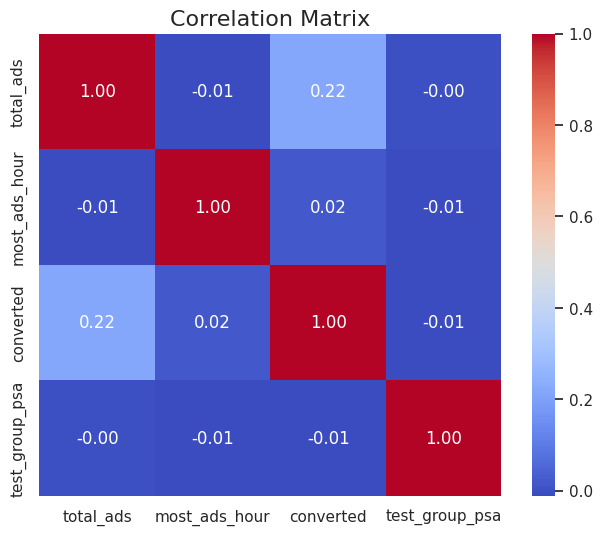

In [15]:
import matplotlib.pyplot as plt

# Selecting relevant columns for correlation analysis
correlation_data = df[['total_ads', 'most_ads_hour', 'converted', 'test_group']]

# Perform one-hot encoding for the 'test_group' column
correlation_data = pd.get_dummies(correlation_data, columns=['test_group'], drop_first=True)

# Compute correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix', fontsize=16)
plt.show()



A correlation matrix provides further insight, identifying a moderate positive correlation (0.22) between the total ads seen and conversions. This suggests that increased ad exposure might potentially enhance conversion rates. However, other factors such as the peak ad-viewing hour and group membership show minimal impact on conversions, highlighting the complex interplay of variables affecting ad effectiveness.

### Balance Checking



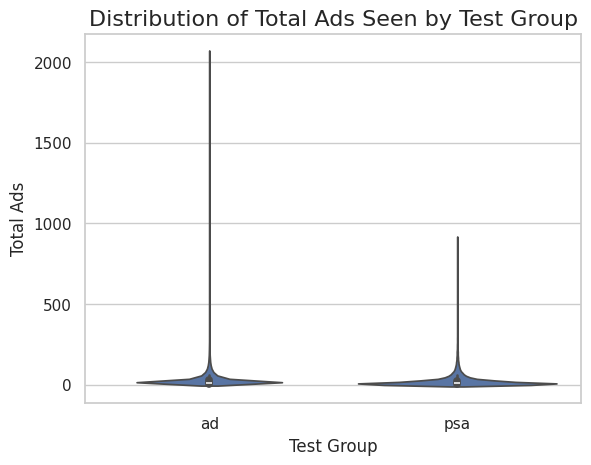

In [16]:
# Plotting the distribution of 'total_ads' for each 'test_group'
sns.violinplot(x='test_group', y='total_ads', data=df)
plt.title('Distribution of Total Ads Seen by Test Group', fontsize=16)
plt.xlabel('Test Group')  # Adding a label for the x-axis
plt.ylabel('Total Ads')  # Adding a label for the y-axis
plt.show()



The violin plot showcases the distribution of 'total ads' seen by two different test groups, 'ad' and 'psa'. The width of each violin indicates the density of data points at different levels of 'total ads', with wider sections representing a higher concentration of observations. While both groups have a similar distribution shape, the 'ad' group has a slightly wider spread, indicating more variability in the number of ads seen.

<ipython-input-17-ceae831945c6>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  barplot = sns.barplot(x='most_ads_day', y='total_ads', hue='test_group', data=df, ci=None)  # ci=None removes the confidence interval bars


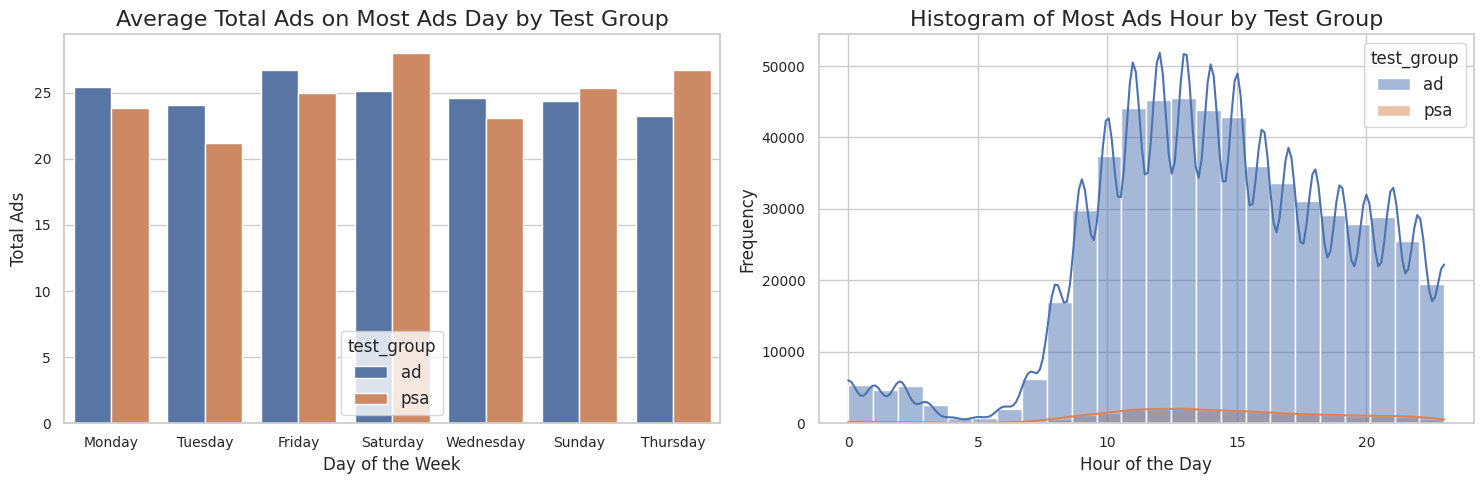

In [17]:

plt.figure(figsize=(15, 5))

# Adjust the font sizes using rcParams for all text elements
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 12, 'axes.titlesize': 14, 'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 12})

# First subplot showing the distribution of 'most_ads_day' using a bar plot
plt.subplot(1, 2, 1)
barplot = sns.barplot(x='most_ads_day', y='total_ads', hue='test_group', data=df, ci=None)  # ci=None removes the confidence interval bars
barplot.set_title('Average Total Ads on Most Ads Day by Test Group', fontsize=16)
barplot.set_xlabel('Day of the Week')  # Optional: Set x-axis label
barplot.set_ylabel('Total Ads')        # Optional: Set y-axis label

# Second subplot showing the distribution of 'most_ads_hour' using a histogram
plt.subplot(1, 2, 2)
histplot = sns.histplot(x='most_ads_hour', hue='test_group', data=df, kde=True, bins=24)  # bins=24 for each hour of the day
histplot.set_title('Histogram of Most Ads Hour by Test Group', fontsize=16)
histplot.set_xlabel('Hour of the Day')  # Optional: Set x-axis label
histplot.set_ylabel('Frequency')        # Optional: Set y-axis label

plt.tight_layout()  # Adjust layout to fit the plots
plt.show()



The bar plot on the left displays the average total ads seen on the most ads day, grouped by test group ('ad' and 'psa'). It indicates that, on average, the 'ad' group tends to see more ads on their most active day compared to the 'psa' group.

On the right, the histogram depicts the distribution of most ads hour by test group. Both groups exhibit a similar pattern, with a peak in the evening hours and a decline overnight. However, the 'ad' group appears to have a slightly broader distribution, suggesting more variability in the timing of ad exposure throughout the day compared to the 'psa' group.

To see if there's a significant difference in the distribution of variables  between the test and control group, we will perform Chi-squared and t tests (for means).

In [18]:
from scipy.stats import chi2_contingency

# Perform a Chi-squared test for 'most_ads_day' vs 'test_group'
day_table = pd.crosstab(df['most_ads_day'], df['test_group'])
_, p_day, _, _ = chi2_contingency(day_table)
print("Chi-squared test: 'most ads day' p-value:", p_day)

# Perform a Chi-squared test for 'most_ads_hour' vs 'test_group'
hour_table = pd.crosstab(df['most_ads_hour'], df['test_group'])
_, p_hour, _, _ = chi2_contingency(hour_table)
print("Chi-squared test: 'most ads hour' p-value:", p_hour)


Chi-squared test: 'most ads day' p-value: 4.849067664297987e-48
Chi-squared test: 'most ads hour' p-value: 1.094573971081402e-28


In [19]:
from scipy.stats import ttest_ind

# Conduct a T-test between 'total_ads' for the 'ad' and 'psa' test groups
group_ad = df[df['test_group'] == 'ad']['total_ads']
group_psa = df[df['test_group'] == 'psa']['total_ads']
t_stat, p_value = ttest_ind(group_ad, group_psa)

# Print the p-value rounded to three decimal places
print(f"T-test p-value: {p_value:.3f}")


T-test p-value: 0.831



The extremely small p-values from the Chi-squared tests (4.85e-48 for 'most ads day' and 1.09e-28 for 'most ads hour') suggest a highly significant statistical association between the test groups and both the days and hours when the most ads were seen. In contrast, the T-test yields a p-value of 0.831, indicating no significant difference in the average number of total ads seen between the 'ad' and 'psa' test groups.

### Propensity Score Matching

In [20]:
# Define the outcome variable and the treatment assignment variable
outcome_var = 'converted'
treatment_var = 'test_group'

# Create dummy variables for categorical columns
df_dummy = pd.get_dummies(df, columns=['most_ads_day', 'most_ads_hour'], drop_first=True, dtype=int)

# Define the independent variables (X) and the dependent variable (y)
X = df_dummy.drop(['id_user', 'test_group', 'converted'], axis=1)
y = df_dummy['test_group'].apply(lambda x: 1 if x == 'ad' else 0)

# Add a constant to the model for the intercept
X = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Get propensity scores from the fitted model
propensity_scores = result.predict(X)

# Output the summary of the model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.167577
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             test_group   No. Observations:               588101
Model:                          Logit   Df Residuals:                   588070
Method:                           MLE   Df Model:                           30
Date:                Fri, 10 May 2024   Pseudo R-squ.:                0.002184
Time:                        02:29:05   Log-Likelihood:                -98552.
converged:                       True   LL-Null:                       -98768.
Covariance Type:            nonrobust   LLR p-value:                 1.257e-72
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3.1128      0.070     44.731      0.000       2.976      

In [22]:

# Select covariates involved in the matching, focusing on features with "ads" in their name
covariates = [col for col in df_dummy.columns if "ads" in col]

# Standardize covariates to ensure distance calculations in NearestNeighbors are scale-invariant
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_dummy[covariates])

# Standardize propensity scores for matching purposes
# Reshaping is required as fit_transform expects 2D arrays
propensity_scores_scaled = scaler.fit_transform(propensity_scores.values.reshape(-1, 1))

# Initialize and fit the NearestNeighbors model
# Using 'ball_tree' for efficient distance calculations, especially useful for large datasets
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
nbrs.fit(propensity_scores_scaled)

# Find the nearest neighbor for each unit based on their propensity score
distances, indices = nbrs.kneighbors(propensity_scores_scaled)

# Create a matched DataFrame based on indices, explicitly making a copy to avoid SettingWithCopyWarning
# Flatten indices array to use for indexing directly
matched_df = df_dummy.iloc[indices.flatten()].copy()

# Safely add a column to matched_df for storing distances, useful for evaluating the quality of matches
matched_df['match_distance'] = distances.flatten()


In [23]:
# Check balance of covariates between treatment and control groups
matched_df.groupby(treatment_var).mean()[covariates + [outcome_var]]

,total_ads,most_ads_day_Monday,most_ads_day_Saturday,most_ads_day_Sunday,most_ads_day_Thursday,most_ads_day_Tuesday,most_ads_day_Wednesday,most_ads_hour_1,most_ads_hour_2,most_ads_hour_3,...,most_ads_hour_15,most_ads_hour_16,most_ads_hour_17,most_ads_hour_18,most_ads_hour_19,most_ads_hour_20,most_ads_hour_21,most_ads_hour_22,most_ads_hour_23,converted
test_group,,,,,,,,,,,,,,,,,,,,,
ad,25.17,0.15,0.14,0.15,0.14,0.14,0.13,0.01,0.01,0.00,...,0.08,0.06,0.06,0.06,0.05,0.05,0.05,0.04,0.04,0.03
psa,19.35,0.16,0.14,0.13,0.13,0.07,0.20,0.01,0.01,0.00,...,0.07,0.08,0.08,0.04,0.08,0.05,0.04,0.05,0.02,0.01


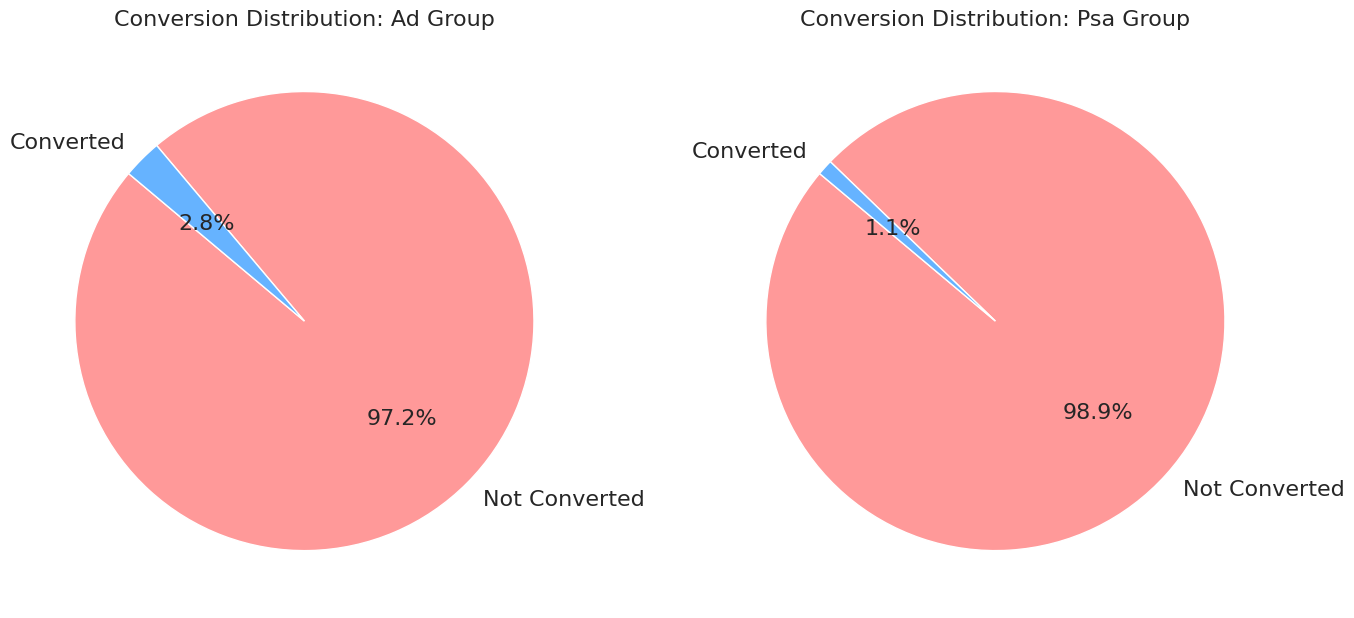

In [24]:

# Aggregate conversion data for each test group and fill missing values with zero
conversion_summary = matched_df.groupby('test_group')['converted'].value_counts(normalize=True).unstack(fill_value=0)

# Create pie charts for each group in one figure
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
labels = ['Not Converted', 'Converted']
colors = ['#ff9999','#66b3ff']  # Adding custom colors for better visual distinction

# Loop to generate pie charts for each test group
for i, group in enumerate(conversion_summary.index):
    axes[i].pie(conversion_summary.loc[group], labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, textprops={'fontsize': 16})
    axes[i].set_title(f'Conversion Distribution: {group.capitalize()} Group', fontsize=16)

plt.tight_layout()
plt.show()



On average, people in the treatment group (who saw ads) viewed approximately 25.17 ads, whereas those in the control group (who saw PSAs) viewed around 19.35 ads. This indicates that being in the treatment group correlates with seeing more ads.

The analysis of the distribution by days shows some differences in when ads were most frequently seen. For example, ads were most often seen on Monday by a slightly larger fraction of the treatment group (0.147) than the control group (0.160). Notably, the control group saw more ads on Wednesday (0.1999), suggesting possible disparities in ad distribution or day-to-day exposure imbalances before matching.

The average conversion rate for the treatment group is approximately 2.8%, demonstrating that a small percentage of those exposed to ads ended up making a purchase or taking the desired action. In contrast, the conversion rate for the control group is about 1.1%, highlighting a positive impact of ad exposure on increasing the likelihood of conversion. The data shows a higher conversion rate in the treatment group compared to the control group.

### Hypothesis Testing

In [25]:
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np

# Create a contingency table of conversions by test group
contingency_table = pd.crosstab(matched_df['converted'], matched_df['test_group'])

# Perform the Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Format expected frequencies to one decimal place
expected_formatted = np.array2string(expected, formatter={'float_kind':lambda x: "%.0f" % x})

# Prepare a DataFrame to display results in a formatted table
results_df = pd.DataFrame({
    "Chi-squared Statistic": [f"{chi2:.2f}"],
    "P-value": [f"{p:.4f}"],
    "Degrees of Freedom": [f"{dof}"],
    "Expected Frequencies": [expected_formatted]
}, index=["Test Results"])

# Display the results DataFrame
styled_results = results_df.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '14pt'), ('text-align', 'center')]},
     {'selector': 'td', 'props': [('font-size', '14pt'), ('text-align', 'center')]}]
).set_caption("Chi-squared Test for Conversion")

styled_results


,Chi-squared Statistic,P-value,Degrees of Freedom,Expected Frequencies
Test Results,346.91,0.0000,1,[[538314 34153] [14701 933]]


The Chi-squared statistic of 346.909 indicates a significant link between the groups and their conversion rates, demonstrating a strong association. The extremely low p-value further supports this, implying that the differences in conversion rates between the groups are not due to random chance.

In summary, exposure to ads correlates with increased conversion rates, highlighting the effectiveness of ads in influencing user behavior. This influence appears to enhance conversion rates by approximately 1.65%. Given these results, it's reasonable to conclude that the advertising campaign has been successful.